# Radar Data Streaming and Pre-Processing

### This notebook demonstrates how to read the data from the radar using python wrapper for Infineon Radar SDK

#### Importing required libraries 

    - ifxdaq --> is the python wrapper for Radar SDK
    - processing --> is python module for basic processing to get the range-Dopplers from the signal
    - fft --> contains the range_fft and doppler_fft methods
    

In [1]:
import ifxdaq
import processing
import numpy as np
#print(ifxdaq.__version__)
from ifxdaq.sensor.radar_ifx import RadarIfxAvian
import matplotlib.pyplot as plot

#### In the folder 'radar_configs' you find radar configuration parameters. It contains radar parameters :

    - transmit power level
    - start/end frequency
    - sampling rate
    - # of chirps per frame
    - # of samples per chirp
    - # of transmit/receive antennas
    - MIMO mode selection

In [10]:
config_file = "radar_configs/RadarIfxBGT60.json"
raw_data    = []
number_of_frames = 5

#### the next code block initiliaze the radar with set configuration and loop through the continuous frames; when it  reaches desired number of frames, we process it to get the range-doppler information out of it.

In [11]:
with RadarIfxAvian(config_file) as device:                             # Initialize the radar with configurations
    
    for i_frame, frame in enumerate(device):                           # Loop through the frames coming from the radar
        
        raw_data.append(np.squeeze(frame['radar'].data/(4095.0)))      # Dividing by 4095.0 to scale the data
        if(i_frame == number_of_frames):       
            data = np.asarray(raw_data)
            range_doppler_map = processing.processing_rangeDopplerData(data)
            #del data
            break
            

#### Note: There is a function to get range_data called "processing_rangeData" which will be usefull to detect the movements.

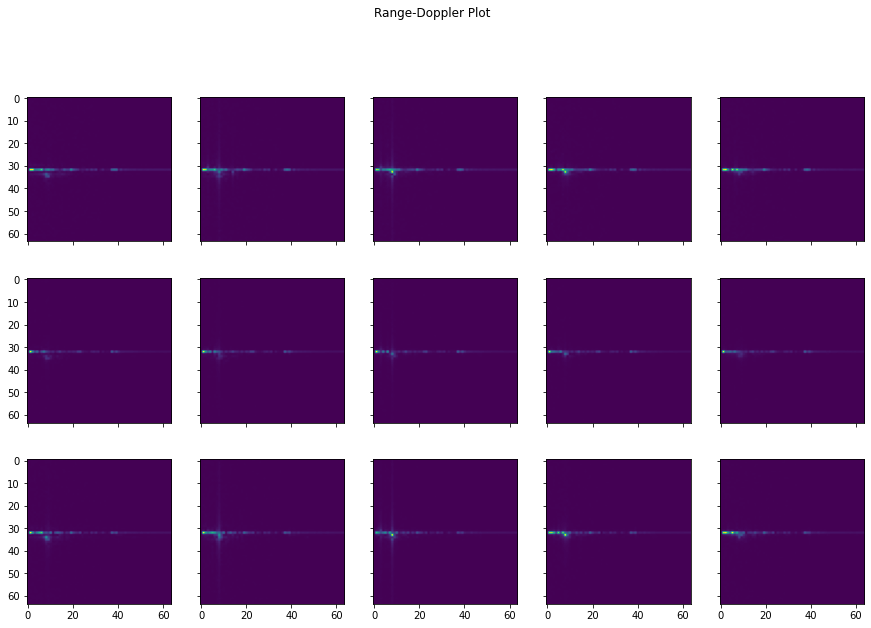

In [12]:
fig, axs = plot.subplots(3, 5,figsize=(15,10),sharex=True, sharey=  True)
fig.suptitle('Range-Doppler Plot')

for i in range(3):
    for j in range(5):
        axs[i, j].imshow(np.abs(range_doppler_map)[j,i,:,:])
        axs[i, j].set_aspect('equal')

plot.subplots_adjust(hspace=0)

